# Classifying Wine from Chemical Attributes

This notebook implements k-means clustering and principal component analysis to classify a wine as either red or white. The wine data is available as 2 `.csv` files (available [here](http://archive.ics.uci.edu/ml/datasets/Wine)), each with 11 attributes:
- Alcohol
- Malic Acis
- Ash
- Alcalinity of ash
- Magnesium
- Total phenois
- Flavanoids
- Nonflavanoid phonols
- Color intensity
- Hue
- OD280/OD315 of diluted wines 
- Proline

## Loading the data
We can load the data here. As we can see from the shapes of the datasets, there are more white than red wines. To remedy this, we will perform undersampling on the white samples such that the number of red and white wines are equal.

In [1]:
import numpy as np
import re

def load_data(path, usecols, dtype=float):
    return np.loadtxt(open(path, 'rb'),
                      delimiter=',', 
                      skiprows=1,
                      dtype=dtype,
                      usecols=usecols)

red_data = load_data(path='./data/redWine.csv', usecols=(0,1,2,3,4,5,6,7,8,9,10))
white_data = load_data(path='./data/whiteWine.csv', usecols=(0,1,2,3,4,5,6,7,8,9,10))
print(f'Red data shape: {red_data.shape}')
print(f'White data shape: {white_data.shape}')

# Undersample the white data
idx = np.random.randint(white_data.shape[0], size=red_data.shape[0])
white_data = white_data[idx, :]

print(f'Undersampled white data: {white_data.shape}')

Red data shape: (1598, 11)
White data shape: (4897, 11)
Undersampled white data: (1598, 11)


## Joining the data
Let's let `White=0` and `Red=1`. That way, we can join our data together and add labels to it.

In [2]:
WHITE = 0
RED = 1
white_labels = np.zeros(white_data.shape[0])
red_labels = np.ones(red_data.shape[0])
labels = np.concatenate((white_labels, red_labels))
data = np.concatenate((white_data, red_data))
labelled_data = np.column_stack((data, labels))

## Implementing K-Means
With the data ready to be used, we can implement a standard K-means algorithm. To initialize the process, we set the positions of the centroids to be the first `k` elements of the data, where `k` is the number of clusters (2, in our case). Then, for `n` iterations, we calculate the euclidean distance from each cluster to each data point and assign the data point to the cluster it is closest to. At the end of each iteration, the cluster's centroid moves to the 'middle' of its data.

In [3]:
def train(data, centroids={}, classes={}, iterations=100, log_interval=None, k=2):
    # Initialize the centroids, the first 'k' elements in the dataset 
    #  will be our initial centroids
    if len(centroids.keys()) == 0:
        for i in range(k):
            centroids[i] = data[i]

    for i in range(iterations):

        if log_interval and i % log_interval == 0 and i != 0:
            print(f'iteration: {i}/{iterations} {(i/iterations)*100}%')

        for i in range(k):
            classes[i] = []

        # Find the distance between the point and cluster
        #  choose the nearest centroid
        for idx, features in enumerate(data):
            distances = [np.linalg.norm(features - centroids[centroid]) for centroid in centroids]
            classification = distances.index(min(distances))
            classes[classification].append(features)

        previous = dict(centroids)

        # Average the cluster datapoints to re-calculate the centroids
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
    return centroids, classes

## Classification Accuracy
Here, we create two methods to help calculate the classification accuracy of the model, by attempting to classify any data passed into it.

In [4]:
def classify(sample, centroids={}):
    distances = [np.linalg.norm(sample - centroids[centroid]) for centroid in centroids]
    return distances.index(min(distances))

def test(features, labels, centroids):
    white_classifications = [0, 0]
    red_classificatons = [0, 0]
    sorted_features = sorted(list(zip(features, labels)), key=lambda tup: tup[1])
    
    for feature, label in sorted_features:
        classification = classify(feature, centroids)
        
        if label == WHITE:
            white_classifications[classification] += 1
        else:
            red_classificatons[classification] += 1
    
    return white_classifications, red_classificatons

## Train
Here, we use K-Fold cross validation with `k=10` to find out which clusters the classifier groups the wines into. Finally, we can print out the accuracy of the clustering when compared to the true labels of the wine.

In [5]:
from sklearn.model_selection import KFold
from operator import add
%matplotlib inline

kf = KFold(n_splits=10)

centroids = {}
classes = {}
white_clf = [0, 0]
red_clf = [0, 0]

for train_idx, test_idx in kf.split(labelled_data):
    centroids, classes = train(data[train_idx], centroids, classes)
    w, r = test(data[test_idx], labels[test_idx], centroids)
    white_clf = list(map(add, white_clf, w))
    red_clf = list(map(add, red_clf, r))
print(f'white classifications: {white_clf}\nred classifications: {red_clf}')

white classifications: [1385, 213]
red classifications: [145, 1453]


In [6]:
white_cluster = white_clf.index(max(white_clf))
red_cluster = red_clf.index(max(red_clf))
white_acc = white_clf[white_cluster]/sum(white_clf)
red_acc = red_clf[red_cluster]/sum(red_clf)
total_acc = white_acc + red_acc 
total_acc /= 2
print(f'White Classification Accuracy: {white_acc*100}%')
print(f'Red Classification Accuracy: {red_acc*100}%')
print(f'Total Classification Accuracy: {total_acc*100}%')

White Classification Accuracy: 86.67083854818523%
Red Classification Accuracy: 90.9261576971214%
Total Classification Accuracy: 88.79849812265333%


## Visualizing the Clusters
Finally, let's use PCA to visualize how the clusters compare to the original data.

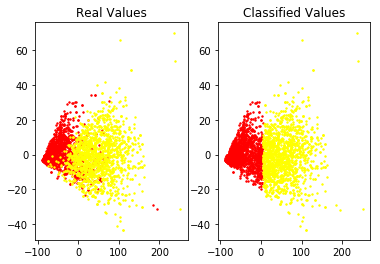

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
decomposed_data = pca.fit_transform(data)

classified_white_idx = []
classified_red_idx = []
for i, d in enumerate(data):
    c = classify(data[i], centroids)
    if c == white_cluster:
        classified_white_idx.append(i)
    else:
        classified_red_idx.append(i)


plt.subplot(1,2,1)
plt.scatter(decomposed_data[red_data.shape[0]:, 0], decomposed_data[red_data.shape[0]:, 1], c='red', s=2)
plt.scatter(decomposed_data[:white_data.shape[0], 0], decomposed_data[:white_data.shape[0], 1], c='yellow', s=2)
plt.title('Real Values')

plt.subplot(1,2,2)
classified_whites = np.take(decomposed_data, classified_white_idx, axis=0)
classified_reds = np.take(decomposed_data, classified_red_idx, axis=0)
plt.scatter(classified_reds[:, 0], classified_reds[:, 1], c='red', s=2)
plt.scatter(classified_whites[:, 0], classified_whites[:, 1], c='yellow', s=2)
plt.title('Classified Values')
plt.show()